# Yarden's Part - SARIMA

## Basic Set Up

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

## EDA

In [314]:
data = pd.read_csv('data_final/with_xal.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data.head(10)

,Close,Crude Oil Price,Jet Fuel Price,Revenue,Net Income,S&P 500,XAL,set
Date,,,,,,,,
2014-11-24,0.990156,0.892607,0.963011,0.443391,0.338313,0.170333,0.405661,train
2014-11-25,1.011697,0.859307,0.942245,0.439180,0.337336,0.168646,0.417473,train
2014-11-26,1.030487,0.855478,0.903310,0.434969,0.336358,0.172757,0.423893,train
2014-11-28,1.112064,0.763903,0.792992,0.426547,0.334403,0.169022,0.497936,train
2014-12-01,1.097169,0.746920,0.832576,0.413914,0.331471,0.159015,0.462012,train
2014-12-02,1.096711,0.751249,0.793640,0.409703,0.330493,0.168306,0.457845,train
2014-12-03,1.105419,0.734599,0.779364,0.405492,0.329516,0.173820,0.469675,train
2014-12-04,1.137729,0.707126,0.791694,0.401281,0.328538,0.172112,0.503550,train
2014-12-05,1.168893,0.699134,0.781960,0.397070,0.327561,0.174557,0.526998,train


In [315]:
AAL = data['Close']
AAL.head(10)

Date
2014-11-24    0.990156
2014-11-25    1.011697
2014-11-26    1.030487
2014-11-28    1.112064
2014-12-01    1.097169
2014-12-02    1.096711
2014-12-03    1.105419
2014-12-04    1.137729
2014-12-05    1.168893
2014-12-08    1.164539
Name: Close, dtype: float64

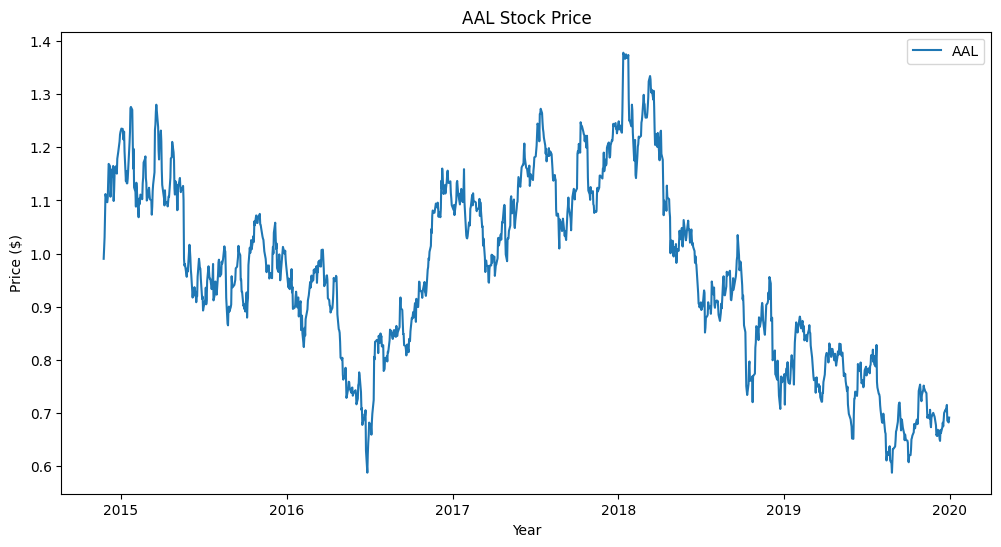

In [316]:
plt.figure(figsize=(12, 6))
plt.plot(AAL)
plt.title('AAL Stock Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend(['AAL'])
plt.show()

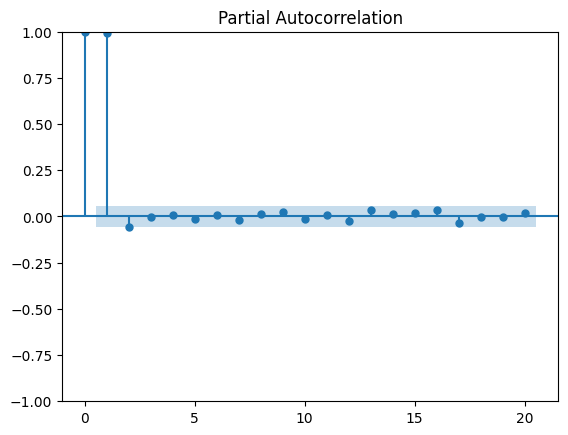

In [317]:
tsaplots.plot_pacf(AAL, lags=20);

In [318]:
AAL_diff = AAL.diff(periods=1).dropna()

As seen in the above graph, only the first term is non-zero. Therefore, we try differencing with $d=1$, i.e. we define the differenced series $Z_t = X_t - X_{t-1}$.

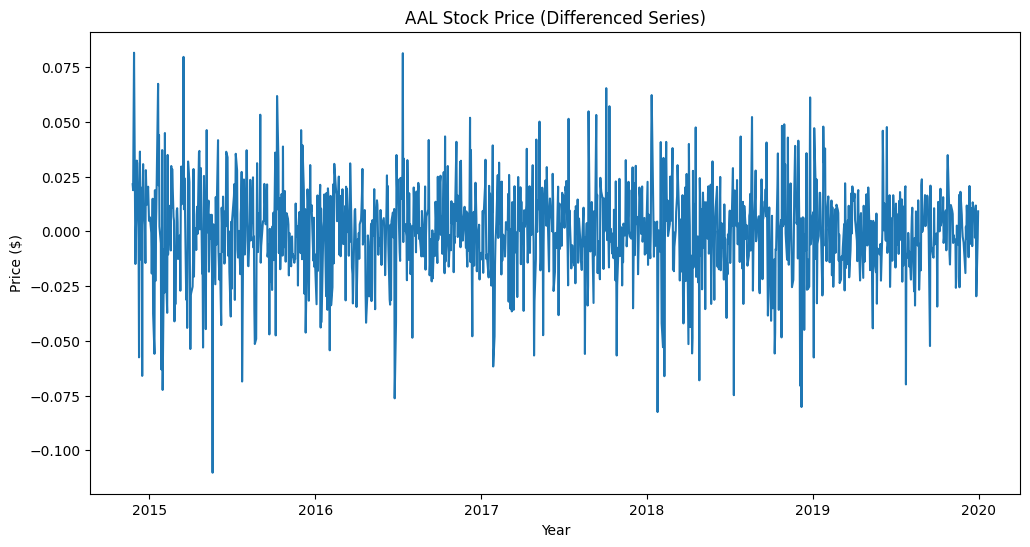

In [319]:
plt.figure(figsize=(12, 6))
plt.plot(AAL_diff)
plt.title('AAL Stock Price (Differenced Series)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show()

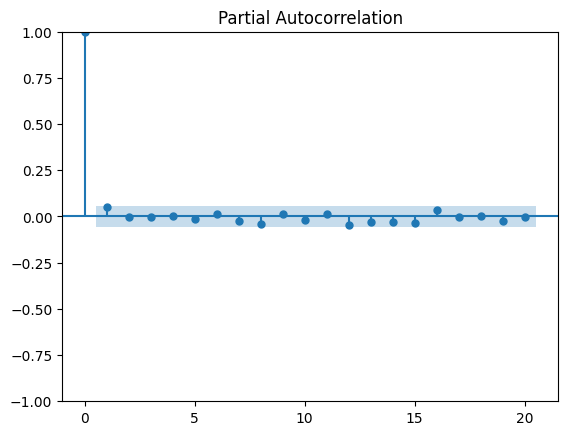

In [320]:
tsaplots.plot_pacf(AAL_diff, lags=20);

## SARIMA

### Dividing to Train, Validation and Test

In [321]:
train = AAL[data['set'] == 'train']
test = AAL[data['set'] == 'test']

In [322]:
def plot_predictions(train, test, predictions, model):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Predictions', color='red')
    plt.title('AAL Stock Price Predictions ' + model)
    plt.xlabel('Year')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()

### Fitting SARIMA Model

As seen in the EDA, the differenced series mitigates the trednd present in the original data. Therefore, we fit a SARIMA model to the differenced series.

In [323]:
auto_sarima_model = auto_arima(train, seasonal=True, m = 5,
                               d = 1, D = 1, 
                               start_p = 0, start_q = 0, max_p = 5, max_q = 5,
                               start_P = 0, start_Q = 0, max_P = 5, max_Q = 5,
                               trace=True, error_action='warn', suppress_warnings=True,
                               random_state=42, n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-3904.183, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-4185.811, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-3905.748, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-4301.268, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=-4367.487, Time=0.67 sec
 ARIMA(1,1,0)(4,1,0)[5]             : AIC=-4398.159, Time=0.74 sec
 ARIMA(1,1,0)(5,1,0)[5]             : AIC=-4438.374, Time=2.84 sec
 ARIMA(1,1,0)(5,1,1)[5]             : AIC=-4434.143, Time=2.95 sec
 ARIMA(1,1,0)(4,1,1)[5]             : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(5,1,0)[5]             : AIC=-4436.646, Time=0.93 sec
 ARIMA(2,1,0)(5,1,0)[5]             : AIC=-4436.515, Time=2.01 sec
 ARIMA(1,1,1)(5,1,0)[5]             : AIC=-4436.279, Time=2.58 sec
 ARIMA(0,1,1)(5,1,0)[5]             : AIC=-4438.270, Time=1.51 sec
 ARIMA(2,1,1)(5,1,0)[5]        

In [324]:
AAL_model = SARIMAX(train, order=auto_sarima_model.order, seasonal_order=auto_sarima_model.seasonal_order)
AAL_fit = AAL_model.fit(disp=False)
AAL_pred = AAL_fit.get_forecast(steps=len(test))
print(AAL_fit.summary())

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  963
Model:             SARIMAX(1, 1, 0)x(5, 1, 0, 5)   Log Likelihood                2226.187
Date:                           Mon, 25 Nov 2024   AIC                          -4438.374
Time:                                   19:07:39   BIC                          -4404.327
Sample:                                        0   HQIC                         -4425.406
                                           - 963                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0629      0.031      2.063      0.039       0.003       0.123
ar.S.L5       -0.8590      0.030    -28.432

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


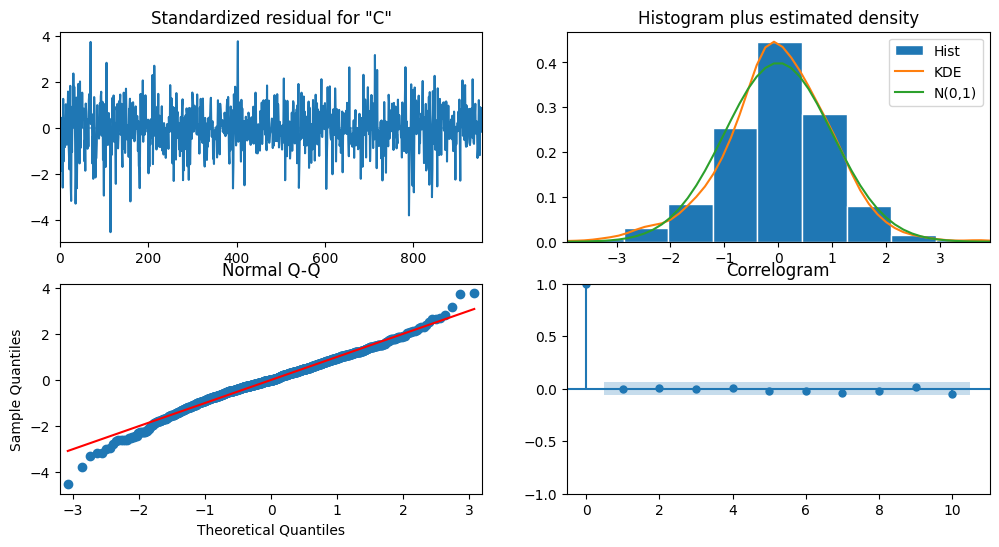

In [325]:
AAL_fit.plot_diagnostics(figsize=(12, 6));

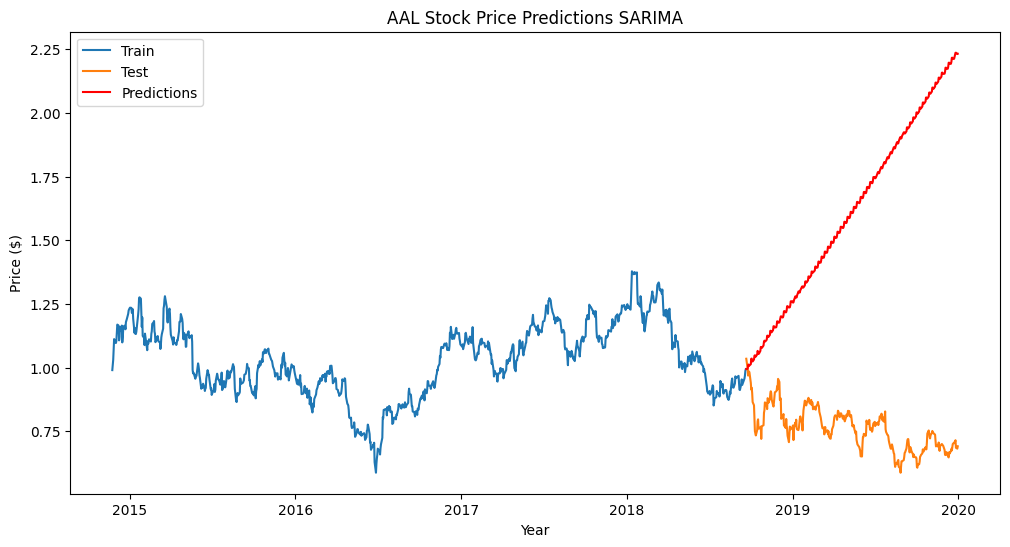

In [326]:
AAL_pred_indexed = AAL_pred.predicted_mean
AAL_pred_indexed.index = test.index
plot_predictions(train, test, AAL_pred_indexed, 'SARIMA')

### RMSE

In [327]:
def calc_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

## Without Exogenous Data

### Predictions with Horizon

In [328]:
def h_step_prediction(h, train, test, fitted_model):
    # Create a copy of the train data to append the predictions
    extended_train = copy.deepcopy(train)
    predictions = pd.Series(dtype=float)

    # Augment the test set with the last h points from the training set
    augmented_test = pd.concat([train[-h:], test])

    for test_index in range(len(augmented_test)):
        # predict exactly h steps ahead
        forecast = fitted_model.get_forecast(steps=h)
        forecast_mean = forecast.predicted_mean  # Extract the forecasted values

        # Store the prediction for the current test point (h days ahead)
        predictions.at[augmented_test.index[test_index]] = forecast_mean.iloc[-1]  # The h'th value in the forecast

        # Add the next real data point from the augmented test set to the training set
        extended_train.at[augmented_test.index[test_index]] = augmented_test.iloc[test_index]

        # Refit the model with the extended training data
        fitted_model = SARIMAX(
            extended_train,
            order=fitted_model.model.order,
            seasonal_order=fitted_model.model.seasonal_order
        ).fit(disp=False)

    return predictions
    

### One Day Ahead

In [329]:
oda_pred = h_step_prediction(1, train, test, copy.deepcopy(AAL_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

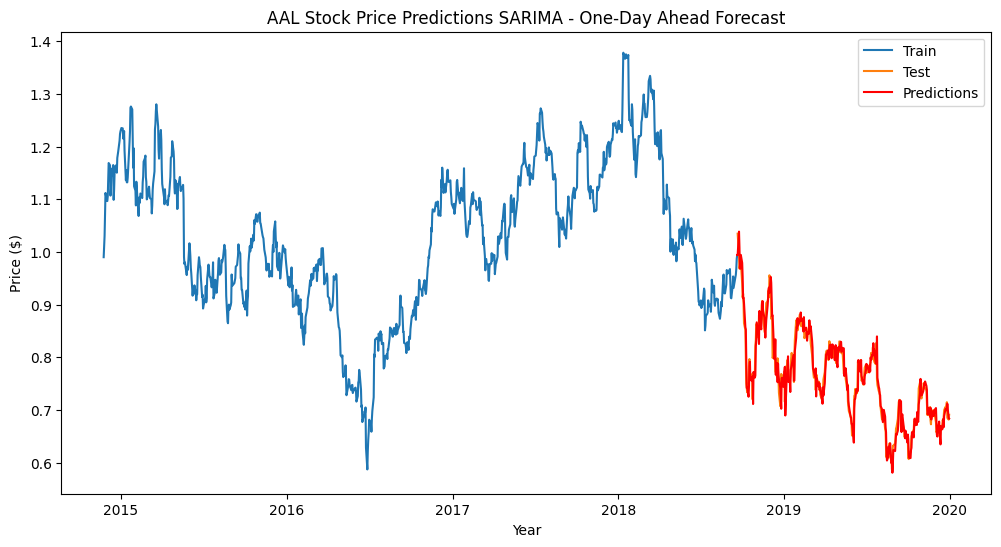

In [330]:
plot_predictions(train, test, oda_pred, 'SARIMA - One-Day Ahead Forecast')

In [331]:
rmse_oda = calc_rmse(test, oda_pred)
print(f'RMSE of One-Day Ahead Forecast: {rmse_oda}')

RMSE of One-Day Ahead Forecast: 0.021521032053904654


### One Week Ahead

In [332]:
fda_pred = h_step_prediction(5, train, test, copy.deepcopy(AAL_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

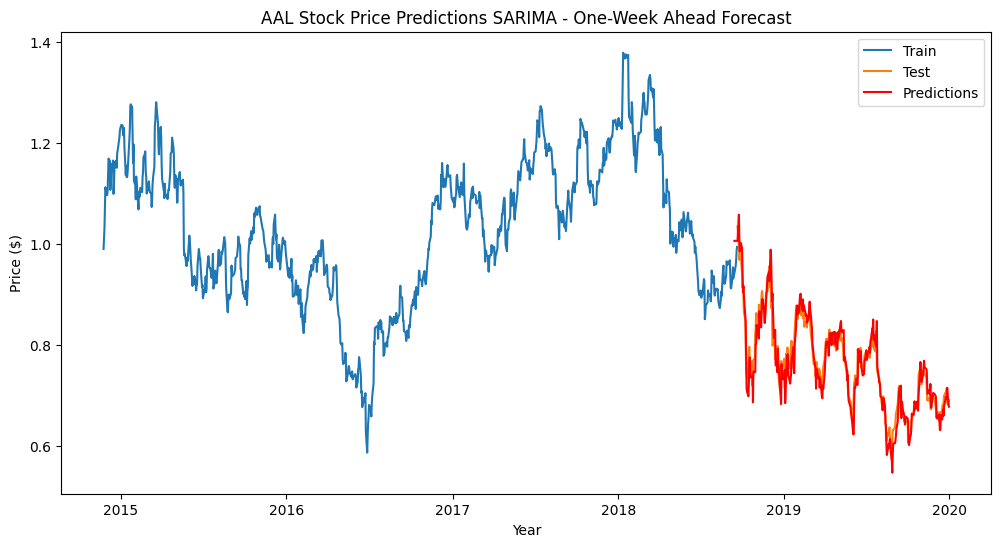

In [333]:
plot_predictions(train, test, fda_pred, 'SARIMA - One-Week Ahead Forecast')

In [334]:
rmse_fda = calc_rmse(test, fda_pred)
print(f'RMSE of One-Week Ahead Forecast: {rmse_fda}')

RMSE of One-Week Ahead Forecast: 0.02722761933119855


### One Month Ahead

In [335]:
oma_pred = h_step_prediction(21, train, test, copy.deepcopy(AAL_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

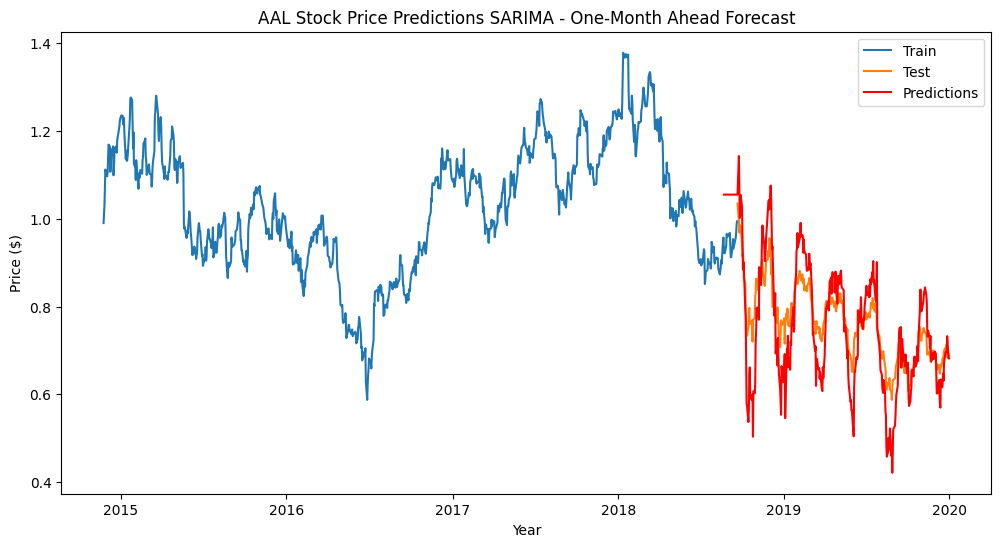

In [336]:
plot_predictions(train, test, oma_pred, 'SARIMA - One-Month Ahead Forecast')

In [337]:
rmse_oma = calc_rmse(test, oma_pred)
print(f'RMSE of One-Month Ahead Forecast: {rmse_oma}')

RMSE of One-Month Ahead Forecast: 0.08037117814369953


## With Exogenous Data

### Dividing to Train and Test

In [338]:
exogenous_data = data[['Crude Oil Price', 'Jet Fuel Price' ,'Revenue', 'Net Income', 'S&P 500', 'XAL']]
exogenous_train = exogenous_data[data['set'] == 'train']
exogenous_test = exogenous_data[data['set'] == 'test']

### Fitting a SARIMA Model

In [339]:
exogenous_auto_sarima_model = auto_arima(train, exogenous=exogenous_train, seasonal=True, m = 5,
                                            d = 1, D = 1, 
                                            start_p = 0, start_q = 0, max_p = 5, max_q = 5,
                                            start_P = 0, start_Q = 0, max_P = 5, max_Q = 5,
                                            trace=True, error_action='warn', suppress_warnings=True,
                                            random_state=42, n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-3904.183, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-4185.811, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-3905.748, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-4301.268, Time=0.70 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=-4367.487, Time=0.65 sec
 ARIMA(1,1,0)(4,1,0)[5]             : AIC=-4398.159, Time=0.89 sec
 ARIMA(1,1,0)(5,1,0)[5]             : AIC=-4438.374, Time=3.28 sec
 ARIMA(1,1,0)(5,1,1)[5]             : AIC=-4434.143, Time=3.79 sec
 ARIMA(1,1,0)(4,1,1)[5]             : AIC=inf, Time=4.28 sec
 ARIMA(0,1,0)(5,1,0)[5]             : AIC=-4436.646, Time=1.22 sec
 ARIMA(2,1,0)(5,1,0)[5]             : AIC=-4436.515, Time=2.59 sec
 ARIMA(1,1,1)(5,1,0)[5]             : AIC=-4436.279, Time=3.58 sec
 ARIMA(0,1,1)(5,1,0)[5]             : AIC=-4438.270, Time=2.11 sec
 ARIMA(2,1,1)(5,1,0)[5]        

In [340]:
AAL_exogenous_model = SARIMAX(train, exogenous=exogenous_train, order=exogenous_auto_sarima_model.order, seasonal_order=exogenous_auto_sarima_model.seasonal_order)
AAL_exogenous_fit = AAL_exogenous_model.fit(disp=False)
AAL_exogenous_pred = AAL_exogenous_fit.get_forecast(steps=len(test), exogenous=exogenous_test)
print(AAL_exogenous_fit.summary())

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exogenous']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  963
Model:             SARIMAX(1, 1, 0)x(5, 1, 0, 5)   Log Likelihood                2226.187
Date:                           Mon, 25 Nov 2024   AIC                          -4438.374
Time:                                   20:11:07   BIC                          -4404.327
Sample:                                        0   HQIC                         -4425.406
                                           - 963                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0629      0.031      2.063      0.039       0.003       0.123
ar.S.L5       -0.8590      0.030    -28.432

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exogenous']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


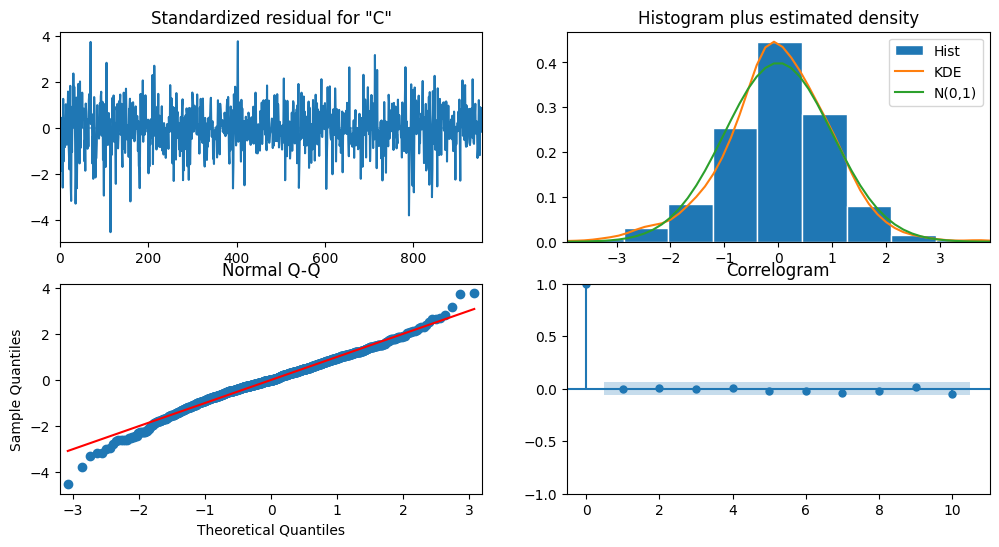

In [341]:
AAL_exogenous_fit.plot_diagnostics(figsize=(12, 6));

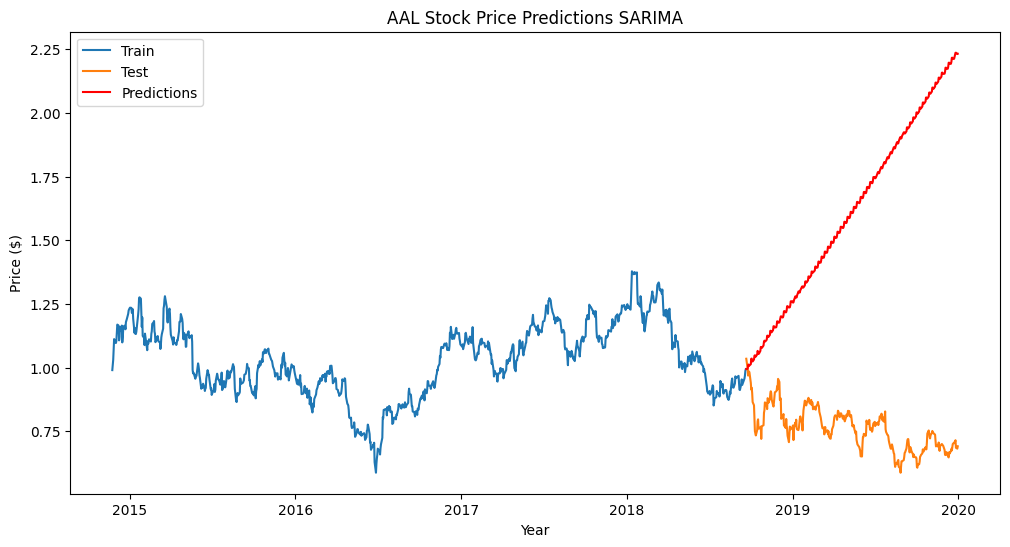

In [342]:
AAL_exogenous_pred_indexed = AAL_exogenous_pred.predicted_mean
AAL_exogenous_pred_indexed.index = test.index
plot_predictions(train, test, AAL_exogenous_pred_indexed, 'SARIMA')

### Predictions with Horizon

In [343]:
def h_step_prediction_exogenous(h, train, test, exog_train, exog_test, fitted_model):
    # Create a copy of the train data to append the predictions
    extended_train = copy.deepcopy(train)
    extended_exog_train = copy.deepcopy(exog_train)
    predictions = pd.Series(dtype=float)

    # Augment the test set with the last h points from the training set
    augmented_test = pd.concat([train[-h:], test])
    augmented_exog_test = pd.concat([exog_train[-h:], exog_test])

    for test_index in range(len(augmented_test)):
        # Predict exactly h steps ahead
        forecast = fitted_model.get_forecast(steps=h, exog=extended_exog_train[-h:])
        forecast_mean = forecast.predicted_mean  # Extract the forecasted values

        # Store the prediction for the current test point (h days ahead)
        predictions.at[augmented_test.index[test_index]] = forecast_mean.iloc[-1]  # The h'th value in the forecast

        # Add the next real data point and its exogenous variables to the training set
        extended_train.at[augmented_test.index[test_index]] = augmented_test.iloc[test_index]
        extended_exog_train.loc[augmented_test.index[test_index]] = augmented_exog_test.iloc[test_index]

        # Refit the model with the extended training data and exogenous variables
        fitted_model = SARIMAX(
            extended_train,
            exog=extended_exog_train,
            order=fitted_model.model.order,
            seasonal_order=fitted_model.model.seasonal_order
        ).fit(disp=False)

    return predictions

### One Day Ahead

In [344]:
oda_pred_exogenous = h_step_prediction_exogenous(1, train, test, exogenous_train, exogenous_test, copy.deepcopy(AAL_exogenous_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

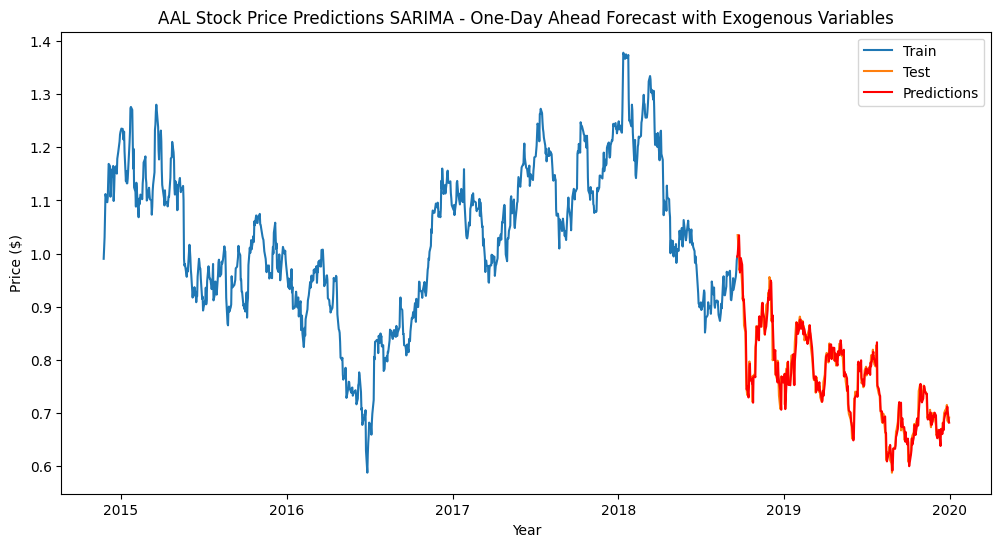

In [345]:
plot_predictions(train, test, oda_pred_exogenous, 'SARIMA - One-Day Ahead Forecast with Exogenous Variables')

In [346]:
oda_rmse_exogenous = calc_rmse(test, oda_pred_exogenous)
print(f'RMSE of One-Day Ahead Forecast with Exogenous Variables: {oda_rmse_exogenous}')

RMSE of One-Day Ahead Forecast with Exogenous Variables: 0.020287597830264504


### One Week Ahead

In [347]:
fda_pred_exogenous = h_step_prediction_exogenous(5, train, test, exogenous_train, exogenous_test, copy.deepcopy(AAL_exogenous_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

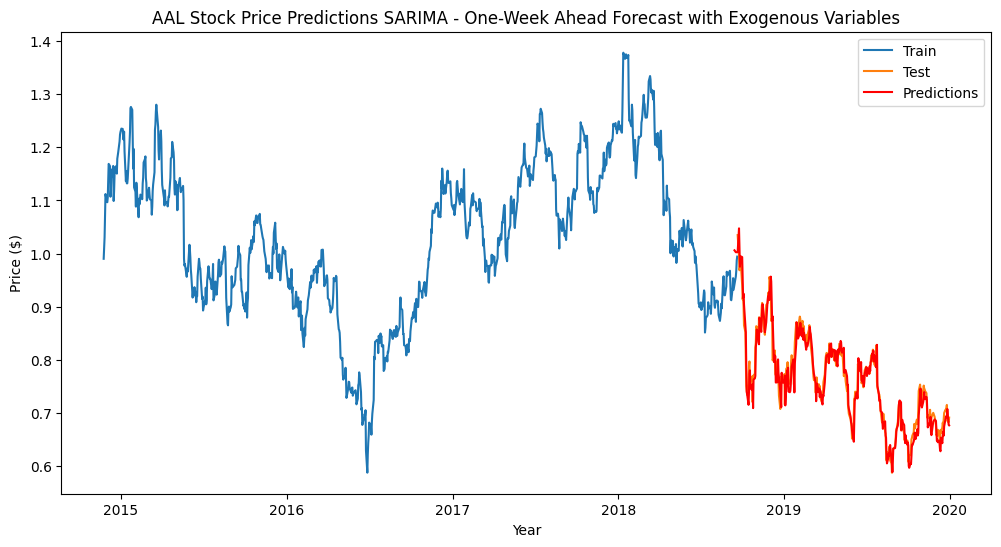

In [348]:
plot_predictions(train, test, fda_pred_exogenous, 'SARIMA - One-Week Ahead Forecast with Exogenous Variables')

In [349]:
rmse_fda_exogenous = calc_rmse(test, fda_pred_exogenous)
print(f'RMSE of One-Week Ahead Forecast with Exogenous Variables: {rmse_fda_exogenous}')

RMSE of One-Week Ahead Forecast with Exogenous Variables: 0.022023297917138755


### One Month Ahead

In [350]:
oma_pred_exogenous = h_step_prediction_exogenous(21, train, test, exogenous_train, exogenous_test, copy.deepcopy(AAL_exogenous_fit))

/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yarden/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so 

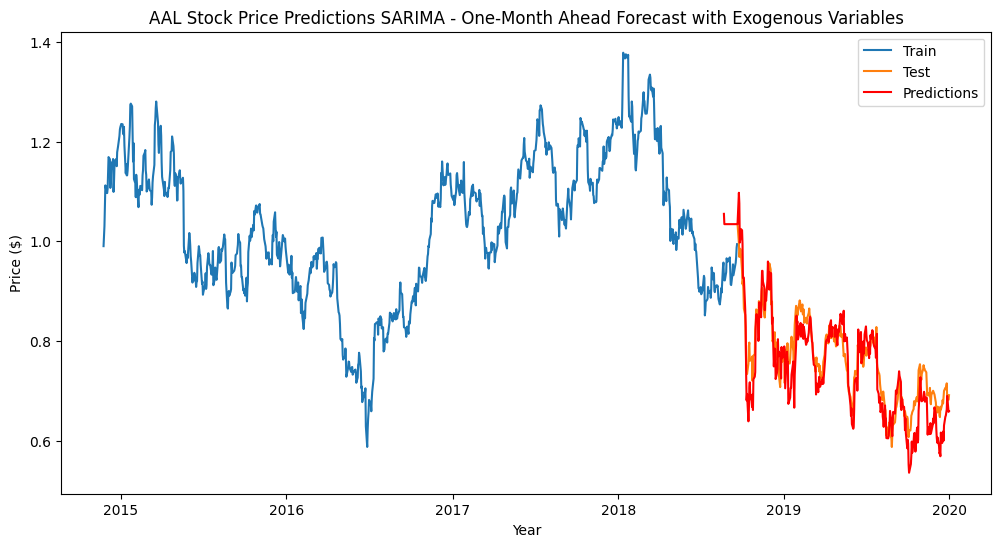

In [351]:
plot_predictions(train, test, oma_pred_exogenous, 'SARIMA - One-Month Ahead Forecast with Exogenous Variables')

In [352]:
rmse_oma_exogenous = calc_rmse(test, oma_pred_exogenous)
print(f'RMSE of One-Month Ahead Forecast with Exogenous Variables: {rmse_oma_exogenous}')

RMSE of One-Month Ahead Forecast with Exogenous Variables: 0.046736513415355674
